Set strain as eps(u) and stress as sigma(u):

\begin{equation}
eps(u) = grad(u)
\end{equation}

\begin{equation}
sigma(u) = lmbda * tr(eps(u)) * Identity(d) + 2 * mu * eps(u)
\end{equation}

The strong form of the problem can be written as follows:

\begin{equation}
\text{div}(\boldsymbol{\sigma}(\mathbf{u})) = \mathbf{f}
\end{equation}

where the strain and stress tensors are defined as follows:

\begin{equation}
\boldsymbol{\varepsilon}(\mathbf{u}) = \nabla \mathbf{u}
\end{equation}

\begin{equation}
\boldsymbol{\sigma}(\mathbf{u}) = \lambda \, \text{tr}(\boldsymbol{\varepsilon}(\mathbf{u})) \, \mathbf{I} + 2 \mu \boldsymbol{\varepsilon}(\mathbf{u})
\end{equation}

To obtain the weak form, we multiply the differential equation by a test function $\mathbf{v}$ and integrate over the entire domain $\Omega$. Choosing $\mathbf{v}$ such that it satisfies the appropriate boundary conditions yields:

\begin{equation}
\int_{\Omega} \text{div}(\boldsymbol{\sigma}(\mathbf{u})) \, \mathbf{v} \, \text{d}\Omega = \int_{\Omega} \mathbf{f} \, \mathbf{v} \, \text{d}\Omega
\end{equation}

By using the divergence theorem, we can transfer the derivatives onto $\mathbf{v}$:

\begin{equation}
\int_{\Omega} \boldsymbol{\sigma}(\mathbf{u}) : \nabla \mathbf{v} \, \text{d}\Omega + \int_{\partial\Omega} (\boldsymbol{\sigma}(\mathbf{u}) \cdot \mathbf{n}) \cdot \mathbf{v} \, \text{d}\Gamma = \int_{\Omega} \mathbf{f} \, \mathbf{v} \, \text{d}\Omega
\end{equation}

where ":" denotes the inner product of two tensors, $\mathbf{n}$ is the outer unit normal on the boundary, and $\text{d}\Gamma$ denotes integration over the boundary.

We can further expand the boundary term for the four boundaries as follows:

\begin{equation}
\int_{\Gamma_1} (\boldsymbol{\sigma}(\mathbf{u}) \cdot \mathbf{n}) \cdot \mathbf{v} \, \text{d}\Gamma - \int_{\Gamma_2} (\boldsymbol{\sigma}(\mathbf{u}) \cdot \mathbf{n}) \cdot \mathbf{v} \, \text{d}\Gamma + \int_{\Gamma_3} (\boldsymbol{\sigma}(\mathbf{u}) \cdot \mathbf{n}) \cdot \mathbf{v} \, \text{d}\Gamma - \int_{\Gamma_4} (\boldsymbol{\sigma}(\mathbf{u}) \cdot \mathbf{n}) \cdot \mathbf{v} \, \text{d}\Gamma
\end{equation}

code in line 30.

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


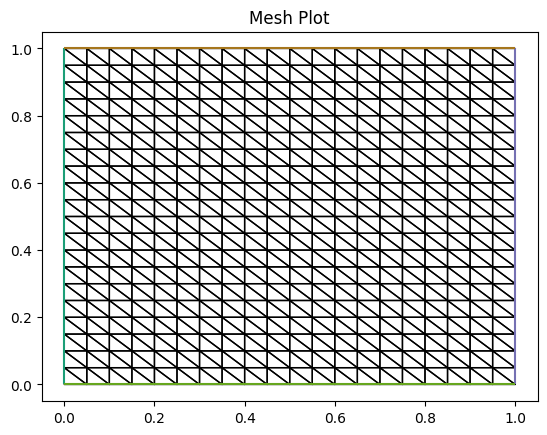

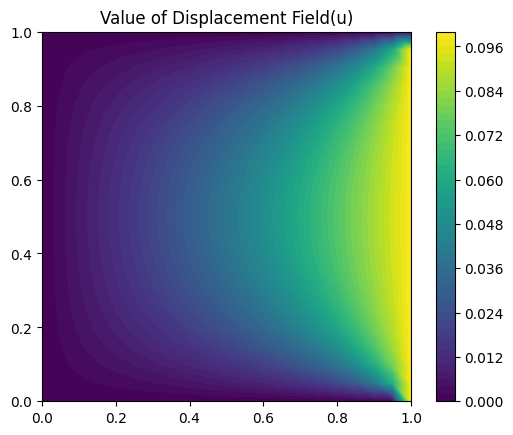

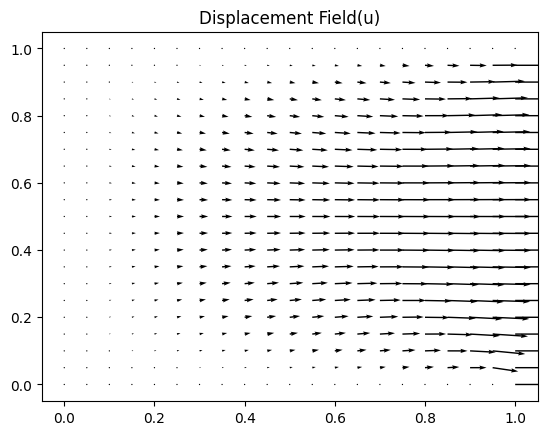

stress_tensor [[ 0.99715909 -0.01136364]
 [-0.01136364  0.11079545]]


array([[ 0.99715909, -0.01136364],
       [-0.01136364,  0.11079545]])

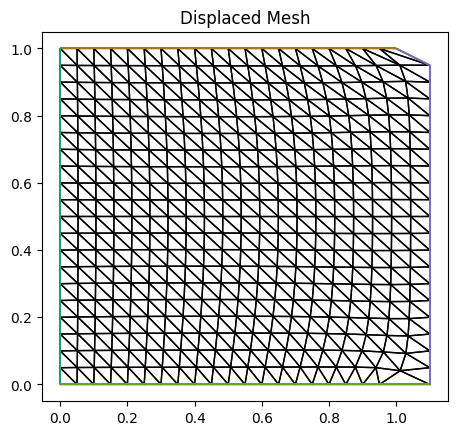

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

def forward_model(E, nu, strain_tensor):
    # Mesh refinement parameters
    nx, ny = 20, 20
    mesh = RectangleMesh(nx, ny, 1, 1)
    x, y = SpatialCoordinate(mesh)
    V = VectorFunctionSpace(mesh, 'CG', 1)
    # Test and trial function for the displacement field
    v, u_ = TestFunction(V), TrialFunction(V)
    u = Function(V, name="Displacement")

    # # Plot the mesh
    fig1, ax1 = plt.subplots()
    triplot(mesh, axes=ax1)
    ax1.set_title("Mesh Plot")

    # Show the plot
    plt.show()

    # Lamé parameter
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # Constitutive equations
    def eps(v):
        return 0.5*(grad(v) + grad(v).T)
    def sigma(v):
        d = 2
        return lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v)
    # Body force
    f = Constant((0.0, 0.0))
    # Facet normal vector in each boundary
    n = FacetNormal(mesh)
    
    # Convert strain tensor into displacement boundary conditions
    exx, eyy, exy = strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]
    uLx = exx * x + exy * y
    uLy = exy * x
    uRx = exx * x + exy * y
    uRy = exy * x
    
    uBx = exy * y
    uBy = eyy * y + exy * x
    uTx = exy * y
    uTy = eyy * y + exy * x

    # Boundary conditions
    bcL = DirichletBC(V, [uLx, uLy], 1)
    bcR = DirichletBC(V, [uRx, uRy], 2)
    bcB = DirichletBC(V, [uBx, uBy], 3)
    bcT = DirichletBC(V, [uTx, uTy], 4)

    # Formal equation is div(sigma(u)) = f
    # Form
    a = inner(sigma(u_), eps(v)) * dx    
    L = inner(f, v) * dx
    # Solve PDE
    solve(a == L, u, bcs=[bcL, bcB, bcR, bcT], solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    # print(u.dat.data)

    fig, axes = plt.subplots()
    axes.set_aspect('equal')
    contours = tricontourf(u, levels=50, axes=axes)
    plt.colorbar(contours)
    plt.title("Value of Displacement Field(u)")
    plt.show()

    # Get the coordinates of the mesh nodes
    coords = mesh.coordinates.dat.data

    # Extract the x and y displacements
    u_values = u.dat.data
    u_x = u_values[:, 0]
    u_y = u_values[:, 1]

    # Create a quiver plot
    plt.quiver(coords[:, 0], coords[:, 1], u_x, u_y)
    plt.title("Displacement Field(u)")
    plt.show()

    sxx = assemble(sigma(u)[0, 0] * dx)
    syy = assemble(sigma(u)[1, 1] * dx)
    sxy = assemble(sigma(u)[0, 1] * dx)
    syx = assemble(sigma(u)[1, 0] * dx)

    stress_tensor = np.array([[sxx, sxy],
                              [syx, syy]])
    print("stress_tensor",stress_tensor)
    
    displaced_coordinates = interpolate(SpatialCoordinate(mesh) + u, V)
    displaced_mesh = Mesh(displaced_coordinates)
    # NBVAL_IGNORE_OUTPUT
    fig, axes = plt.subplots()
    axes.set_title("Displaced Mesh")

    triplot(displaced_mesh, axes=axes)
    axes.set_aspect("equal");
        
    # # Plot stress
    # s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
    # von_Mises = sqrt(3./2*inner(s, s))
    # V1 = FunctionSpace(mesh, "CG",1)
    # von_Mises = project(von_Mises, V1)
    # tricontourf(von_Mises, levels=50, title='Stress intensity')

    return stress_tensor

E = 10
nu = 0.1

strain_tensor = np.array([[0.1, 0],
                          [0, 0]])
forward_model(E, nu, strain_tensor)



In [3]:
# check 
E = 10
nu = 0.1
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
eps = np.array([[0.1, 0],
                [0, 0]])
# lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v), 0.1 is the trace of eps(v)
s = lmbda*0.1*np.array([[1, 0],[0, 1]]) + 2*mu*eps
s

array([[1.02272727, 0.        ],
       [0.        , 0.11363636]])

calculate by firedrake:

stress_tensor [[ 0.99715909 -0.01136364]
                [-0.01136364  0.11079545]]

## Case 2: strain in y direction

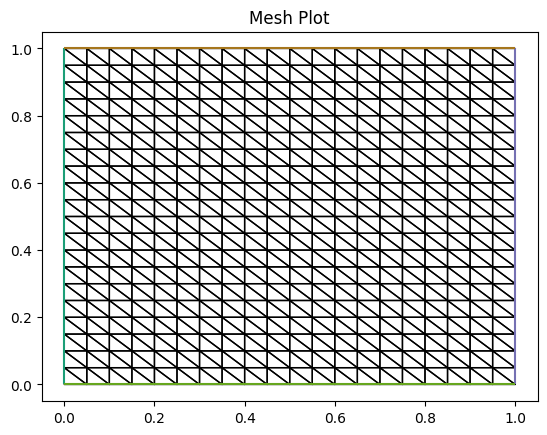

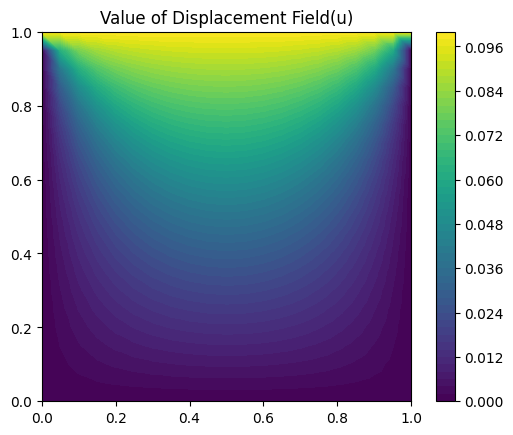

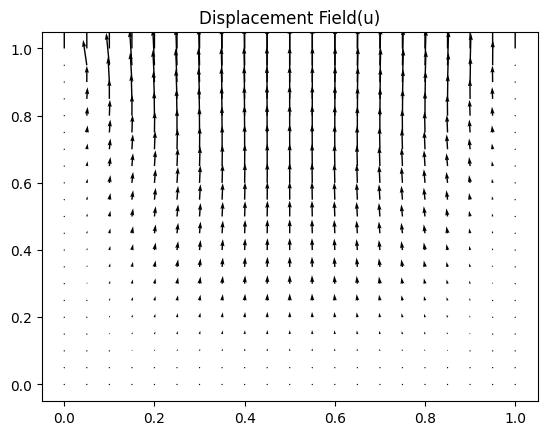

stress_tensor [[1.13636364e-01 1.19538218e-16]
 [1.19538218e-16 1.02272727e+00]]


array([[1.13636364e-01, 1.19538218e-16],
       [1.19538218e-16, 1.02272727e+00]])

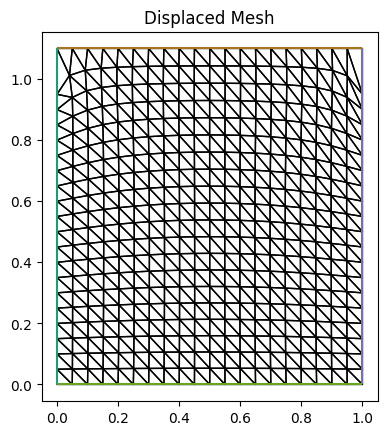

In [4]:
E = 10
nu = 0.1

strain_tensor = np.array([[0, 0],
                          [0, 0.1]])
forward_model(E, nu, strain_tensor)

In [5]:
E = 10
nu = 0.1
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
eps = np.array([[0, 0],
                [0, 0.1]])
s = lmbda*0.1*np.array([[1, 0],[0, 1]]) + 2*mu*eps
s

array([[0.11363636, 0.        ],
       [0.        , 1.02272727]])

calculate by firedrake:

stress_tensor [[1.13636364e-01 1.19538218e-16]
                [1.19538218e-16 1.02272727e+00]]

## Case 3: strain in shear

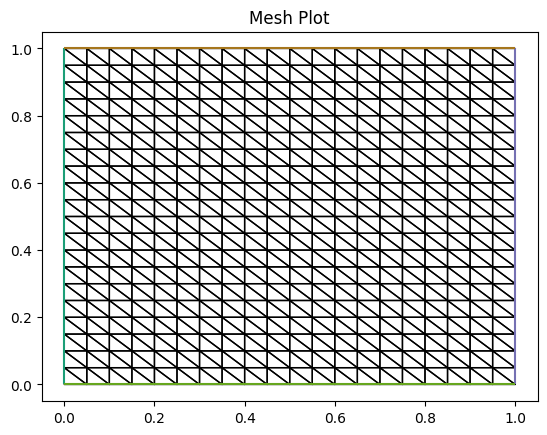

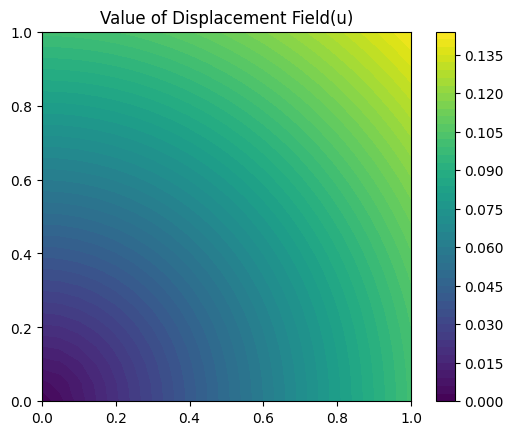

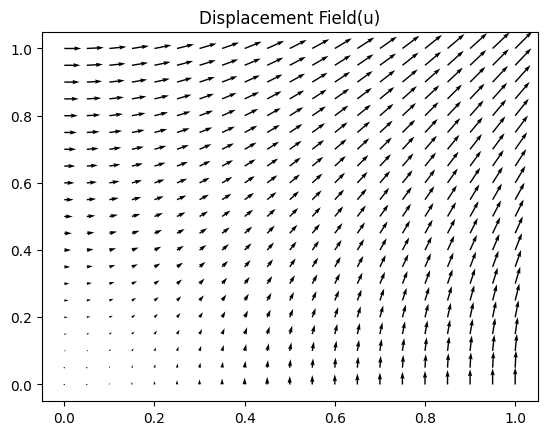

stress_tensor [[-1.34108416e-17  9.09090909e-01]
 [ 9.09090909e-01 -3.44648158e-19]]


array([[-1.34108416e-17,  9.09090909e-01],
       [ 9.09090909e-01, -3.44648158e-19]])

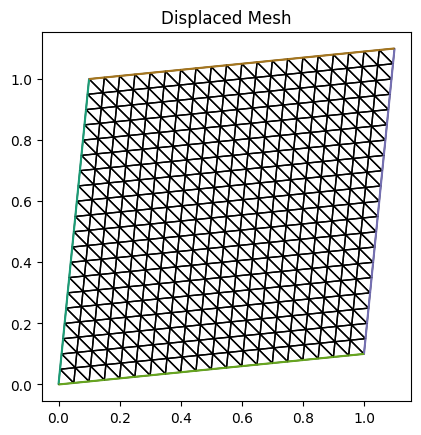

In [6]:
E = 10
nu = 0.1

strain_tensor = np.array([[0, 0.1],
                          [0.1, 0]])
forward_model(E, nu, strain_tensor)

In [7]:
E = 10
nu = 0.1
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
eps = np.array([[0, 0.1],
                [0.1, 0]])
s = lmbda*0.0*np.array([[1, 0],[0, 1]]) + 2*mu*eps
s

array([[0.        , 0.90909091],
       [0.90909091, 0.        ]])

calculate by firedrake:

stress_tensor [[-1.34108416e-17  9.09090909e-01]
 [ 9.09090909e-01 -3.44648158e-19]]

## Case 4: strain in all direction

In [9]:
E = 10
nu = 0.1
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
eps = np.array([[0.3, 0.2],
                [0.2, 0.4]])
s = lmbda*0.7*np.array([[1, 0],[0, 1]]) + 2*mu*eps
s

array([[3.52272727, 1.81818182],
       [1.81818182, 4.43181818]])

calculate by firedrake:

array([[3.44602273, 1.78409091],
       [1.78409091, 4.42329545]])

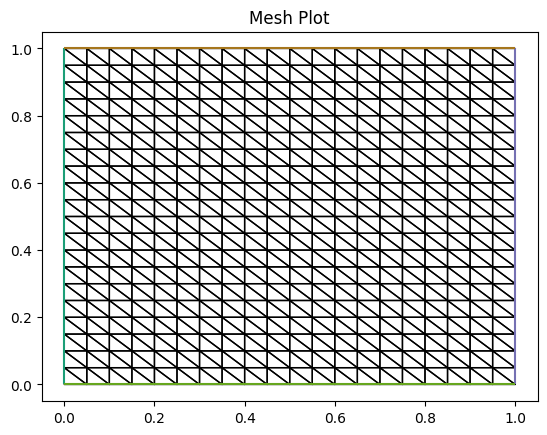

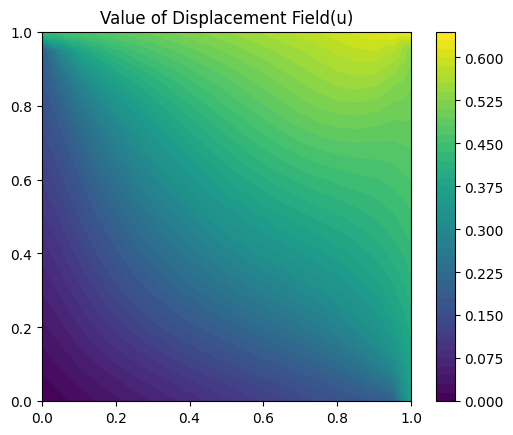

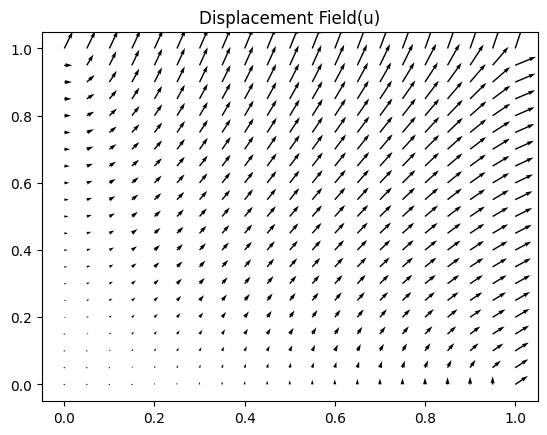

stress_tensor [[3.44602273 1.78409091]
 [1.78409091 4.42329545]]


array([[3.44602273, 1.78409091],
       [1.78409091, 4.42329545]])

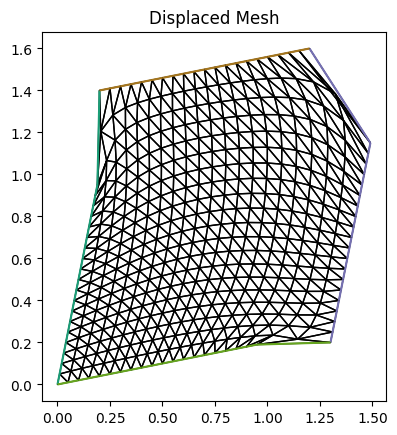

In [8]:
E = 10
nu = 0.1

strain_tensor = np.array([[0.3, 0.2],
                          [0.2, 0.4]])
forward_model(E, nu, strain_tensor)